This notebook uses the Scientific Python (scipy) stack tools to generate flow duration curves from current USGS NWIS data.

Using recipes from this notebook, you can make:
* USGS Station Summaries
* Flow duration curves
* Iterative import and compilation of USGS station information and data
* boxplots using pandas
* iterative charts (one monthly summary boxplot per station)
* Gantt charts of USGS stations

## Background

Check out this for some great `pandas` applications:
http://earthpy.org/time_series_analysis_with_pandas_part_2.html

In [1]:
%matplotlib inline
import pandas as pd
import urllib2
from pyproj import Proj, transform
import xmltodict
import numpy as np
from datetime import datetime, date, timedelta
import mechanize
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
huc = '16010203,16010202'
stationhtml = "http://waterservices.usgs.gov/nwis/site/?format=rdb,1.0&huc="+str(huc)+"&siteType=GW&hasDataTypeCd=gw"
response = urllib2.urlopen(stationhtml)
html = response.read()
skip = html[:html.rfind('#\n')+2].count('\n')
skiplist = range(0,skip)
skiplist.append(skip+1)
sites = pd.read_table(stationhtml,sep="\t",skiprows=skiplist)
stations = list(sites['site_no'].values)
stations = [str(i) for i in stations]
#stations = ', '.join(stations)
#stations = stations.replace(" ","")


In [3]:
stations

['413125111484701',
 '413142111480801',
 '413157111484501',
 '413158111485301',
 '413237111493201',
 '413251111494001',
 '413300111493901',
 '413359111493001',
 '413403111491401',
 '413429111501601',
 '413451111505501',
 '413516111554101',
 '413516111554201',
 '413524111501801',
 '413535111545601',
 '413550111500601',
 '413552111560201',
 '413558111554301',
 '413601111500801',
 '413609111495701',
 '413616111495001',
 '413616111495701',
 '413629111543201',
 '413633111542001',
 '413634111535701',
 '413644111532501',
 '413657111493501',
 '413658111543301',
 '413703111562401',
 '413704111543801',
 '413705111562301',
 '413734111532401',
 '413737111532301',
 '413737111532302',
 '413738111495301',
 '413802111495701',
 '413804111515801',
 '413805111492201',
 '413809111490101',
 '413818111501701',
 '413822111532901',
 '413825111555601',
 '413826111533001',
 '413827111532501',
 '413838111513501',
 '413840111552601',
 '413841111490401',
 '413845111513501',
 '413848111533001',
 '413848111545101',


In [4]:
sitesinfo = {}
for station in stations:
    stationinfohtml = "http://waterservices.usgs.gov/nwis/site/?format=rdb&sites="+station+"&siteOutput=expanded"
    response = urllib2.urlopen(stationinfohtml)
    html = response.read()
    skip = html[:html.rfind('#\n')+2].count('\n')
    skiplist = range(0,skip)
    skiplist.append(skip+1)
    sitesinfo[station] = pd.read_table(stationinfohtml, sep="\t",skiprows=skiplist)


In [5]:
siteinfo = pd.concat(sitesinfo)

In [6]:
siteinfo.columns

Index([u'agency_cd', u'site_no', u'station_nm', u'site_tp_cd', u'lat_va',
       u'long_va', u'dec_lat_va', u'dec_long_va', u'coord_meth_cd',
       u'coord_acy_cd', u'coord_datum_cd', u'dec_coord_datum_cd',
       u'district_cd', u'state_cd', u'county_cd', u'country_cd',
       u'land_net_ds', u'map_nm', u'map_scale_fc', u'alt_va', u'alt_meth_cd',
       u'alt_acy_va', u'alt_datum_cd', u'huc_cd', u'basin_cd', u'topo_cd',
       u'instruments_cd', u'construction_dt', u'inventory_dt',
       u'drain_area_va', u'contrib_drain_area_va', u'tz_cd', u'local_time_fg',
       u'reliability_cd', u'gw_file_cd', u'nat_aqfr_cd', u'aqfr_cd',
       u'aqfr_type_cd', u'well_depth_va', u'hole_depth_va', u'depth_src_cd',
       u'project_no'],
      dtype='object')

In [7]:
def getelev(x):
    elev = "http://ned.usgs.gov/epqs/pqs.php?x="+str(x[0])+"&y="+str(x[1])+"&units=Meters&output=xml"
    response = urllib2.urlopen(elev)
    html = response.read()
    d = xmltodict.parse(html)
    return float(d['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])

In [8]:
def getwlelev(x):
    return x[1] - (x[0]/3.2808)

In [9]:
def qqq(x):
    x.rstrip().lstrip()
    j = x.split(' ')
    a = j[0][:1]
    b = j[0][1:]
    c = j[1][:1]
    d = j[1][1:]
    e = [a,b,c,d,j[2],j[3],j[4],j[5],j[6]]
    
    NS = int(e[1].replace(',',''))
    EW = int(e[3].replace(',',''))
    qc = e[4]
    d1 = e[0]
    d2 = e[2]
    dic1 = {'NE':'a','NW':'b','SW':'c','SE':'d'}
    qcdDict = {'E4S':'d','E4N':'a','N4E':'a','N4W':'b','W4N':'b','W4S':'c','S4W':'c','S4E':'d'}
    dic2 = {'a':'b','b':'a','c':'d','d':'c'}
    dic3 = {'a':'d','b':'c','c':'b','d':'a'}
    dic4 = {'a':'c','b':'d','c':'a','d':'b'}
    if qc[-1]=='4':
        if qc[0]=='N' or qc[0]=='S':
            qcd = qc+d2
        elif qc[0]=='E' or qc[0]=='W':
            qcd = qc+d1
        q1 = qcdDict.get(qcd,'x')
    elif qc in ('NE','NW','SW','SE'):
        q1 = dic1.get(qc)
    else:
        print "invalid quarter"
        q1 = 'X'
    if NS < 1320:
        if EW <1320:
            q2 = q1
        elif EW >1320:
            qd2 = {'a':'b','b':'a','c':'d','d':'c'}
            q2 = dic2.get(q1,'x')
    elif NS > 1320:
        if EW <1320:
            q2 = dic3.get(q1,'x')
        elif EW >1320:
            q2 = dic4.get(q1,'x')
    else:
        q2 = 'X'

    if NS < 660 or (NS > 1320 and NS < 1980):
        if (EW < 660) or (EW > 1320 and EW < 1980):
            q3 = q1
        elif (EW > 660 and EW < 1320) or (EW > 1980 and EW < 2640):
            q3 = dic2.get(q1,'x')
    elif (NS > 660 and NS < 1320) or (NS > 1980 and NS < 2640):
        if (EW < 660) or (EW > 1320 and EW < 1980):
            q3 = dic3.get(q1,'x')
        elif (EW > 660 and EW < 1320) or (EW > 1980 and EW < 2640):
            q3 = dic4.get(q1,'x')
    else:
        q3 = 'X'
    Tn = e[6][:-1].rjust(2)
    Rn = e[7][:-1].rjust(2)
    Sec = e[5].rjust(2)
    TRd = e[6][-1]+e[7][-1]
    TR = dic1.get(TRd).upper()
    CAD = '('+TR+'-'+Tn+'-'+Rn+')'+Sec+q1+q2+q3+'-1'
    return CAD                

In [10]:
def getPLSS(desc):
    PLSStitlen = len("PLSS Description is </font><font size='4'> ")
    PLSSbeg = desc.find("PLSS Description is </font><font size='4'>")+PLSStitlen
    PLSSend = desc[PLSSbeg:].find(" <br> ")+PLSSbeg
    PLSSdesc = desc[PLSSbeg:PLSSend]
    QRTRend = desc.find(" of the above Section </font></center><p>")
    QRTRbeg = desc.find("The point is found in the ")+len("The point is found in the ")
    QRTRdesc = desc[QRTRbeg:QRTRend]
    SecBeg = PLSSdesc.find("Section ")+len("Section ")
    SecEnd = PLSSdesc.find(", Township ")
    Section = int(PLSSdesc[SecBeg:SecEnd])
    TownBeg = SecEnd + len(", Township ")
    TownEnd = PLSSdesc.find(", Range ")
    Township = PLSSdesc[TownBeg:TownEnd]
    RangeBeg = TownEnd + len(", Range ")
    RangeEnd = RangeBeg + PLSSdesc[RangeBeg:].find(", ")
    Range = PLSSdesc[RangeBeg:RangeEnd]

    PLSS = PLSSdesc.replace("South ","S")
    PLSS = PLSS.replace("West ","W")
    PLSS = PLSS.replace("North ","N")
    PLSS = PLSS.replace("East ","E")
    PLSS = PLSS.replace("feet ","")
    PLSS = PLSS.replace(" and "," ")
    PLSS = PLSS.replace("from the ","")
    BM = PLSS[-6:-4]
    PLSScn = PLSS.find(" Corner")
    PLSS = PLSS[:PLSScn]
    PLSS = PLSS.replace(',','')
    PLSS = PLSS + " " +str(Section) + " " + Township + " " + Range + " " + BM
    
    try:
        CAD = qqq(PLSS)
    except(AttributeError,TypeError,UnboundLocalError):
        #print PLSS
        CAD = np.nan
    return PLSS, CAD

In [11]:
PLSS = 'N337 E1,117 W4 3 9N 1E SL'
print qqq(PLSS)

(A- 9- 1) 3bba-1


In [12]:
def proj(x):
    inProj = Proj(init='epsg:4326') #WGS84
    outProj = Proj(init='epsg:2152') #NAD83(CSRS98) / UTM zone 12N
    x2,y2 = transform(inProj,outProj,x[0],x[1])
    return x2, y2

def projy(x):
    inProj = Proj(init='epsg:4326') #WGS84
    outProj = Proj(init='epsg:2152') #NAD83(CSRS98) / UTM zone 12N
    x2,y2 = transform(inProj,outProj,x[0],x[1])
    return y2

def projx(x):
    inProj = Proj(init='epsg:4326') #WGS84
    outProj = Proj(init='epsg:2152') #NAD83(CSRS98) / UTM zone 12N
    x2,y2 = transform(inProj,outProj,x[0],x[1])
    return x2

siteinfo['UTM_X'] = siteinfo[['dec_long_va','dec_lat_va']].apply(lambda x: projx(x),1)
siteinfo['UTM_Y']= siteinfo[['dec_long_va','dec_lat_va']].apply(lambda x: projy(x),1)

In [13]:
def USGSID(x):
    def dms(dec):
        DD = str(int(abs(dec)))
        MM = str(int((abs(dec) - int(DD))*60)).zfill(2)
        SS = str(int(round((((abs(dec) - int(DD))*60) - int(MM))*60, 0))).zfill(2)
        return DD+MM+SS
    return 'UT'+dms(x[1])+dms(x[0])+'01'

In [14]:
def getwellinfo(x):
    request = mechanize.Request("http://maps.waterrights.utah.gov/asp/location.asp")
    response = mechanize.urlopen(request)
    forms = mechanize.ParseResponse(response, backwards_compat=False)
    response.close()
    form = forms[0]
    form["UTMx"]= str(x[0])
    form["UTMy"]= str(x[1])
    form["datumutm"]=["NAD83"]
    desc =  mechanize.urlopen(form.click()).read()
    try:
        PLSS, CAD = getPLSS(desc)
    except(ValueError):
        PLSS, CAD = np.nan, np.nan
    return PLSS, CAD

def getwellPLSS(x):
    request = mechanize.Request("http://maps.waterrights.utah.gov/asp/location.asp")
    response = mechanize.urlopen(request)
    forms = mechanize.ParseResponse(response, backwards_compat=False)
    response.close()
    form = forms[0]
    form["UTMx"]= str(x[0])
    form["UTMy"]= str(x[1])
    form["datumutm"]=["NAD83"]
    desc =  mechanize.urlopen(form.click()).read()
    try:
        PLSS, CAD = getPLSS(desc)
    except(ValueError):
        PLSS, CAD = np.nan, np.nan
    return PLSS

def getwellCAD(x):
    request = mechanize.Request("http://maps.waterrights.utah.gov/asp/location.asp")
    response = mechanize.urlopen(request)
    forms = mechanize.ParseResponse(response, backwards_compat=False)
    response.close()
    form = forms[0]
    form["UTMx"]= str(x[0])
    form["UTMy"]= str(x[1])
    form["datumutm"]=["NAD83"]
    desc =  mechanize.urlopen(form.click()).read()
    try:
        PLSS, CAD = getPLSS(desc)
    except(ValueError):
        PLSS, CAD = np.nan, np.nan
    return PLSS

http://wwwsearch.sourceforge.net/mechanize/forms.html

In [15]:
def winmatch(x):
    request = mechanize.Request("http://waterrights.utah.gov/wellinfo/wellsearch.asp")
    response = mechanize.urlopen(request)
    forms = mechanize.ParseResponse(response, backwards_compat=False)
    response.close()
    form = forms[0] 
    #print form
    form["mainoption"]=["radius"]
    form["SearchRadius"]="2000"
    form["option"]=["UTM"]
    form["xUTM"]=str(x[0])
    form["yUTM"]=str(x[1])
    if np.isfinite(x[2]):
        form["DateRange"]=["on"]
        form["edtDrillBef"]=str(int(str(x[2])[:4])+5)
        form["edtDrillAft"]=str(int(str(x[2])[:4])-5)
        #print str(int(str(x[2])[:4]))
    if np.isfinite(x[3]):
        form["DepthRange"]=["on"]
        form["edtDrillBel"]=str(int(x[3])-10)
        form["edtDrillAbo"]=str(int(x[3])+30)
        #print str(str(int(x[3])))
    win =  mechanize.urlopen(form.click()).read()
    winbeg = win.find('WIN=')
    if winbeg == -1:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan 
    else:
        wintabeg=win.find('<table',win.find('<table')+5)
        wintaend=win.find('</table>')
        winmatches = pd.read_html(win[wintabeg:wintaend], header=0, skiprows=0)
        winmatches = winmatches[0]
        winDic = {u'WRNUM/Appl. No.':'WRNUM',u'Distance From Point (ft)':'DIST',u'Diameter':'Diam',u'Depth':'TD',
          u'Drilled Date':'DrillDate',u'Location(link to Log)':'Locatio',u'WIN':'WIN',u'Geologic Log':'Log'}
        winmatches.rename(columns=winDic,inplace=True)
        return winmatches.ix[0,0], winmatches.ix[0,1], winmatches.ix[0,2], winmatches.ix[0,3], winmatches.ix[0,4], winmatches.ix[0,5], int(winmatches.ix[0,6])

winDic = {u'WRNUM/Appl. No.':'WRNUM',u'Distance From Point (ft)':'DIST',u'Diameter':'Diam',u'Depth':'TD',
          u'Drilled Date':'DrillDate',u'Location(link to Log)':'Locatio',u'WIN':'WIN',u'Geologic Log':'Log'}
winmatches.rename(columns=winDic,inplace=True)
list(winmatches.ix[0])

In [16]:
siteinfo['Elev'] = siteinfo[['dec_long_va','dec_lat_va']].apply(lambda x: getelev(x),1)

In [17]:
siteinfo['USGSid'] = siteinfo[['dec_long_va','dec_lat_va']].apply(lambda x: USGSID(x),1)

In [18]:
siteinfo['PLSS'] = siteinfo[['UTM_X','UTM_Y']].apply(lambda x: getwellPLSS(x),1)
siteinfo['CAD']  = siteinfo[['UTM_X','UTM_Y']].apply(lambda x: getwellCAD(x),1)

In [19]:
siteinfo['WRNUM'] = siteinfo[['UTM_X','UTM_Y','construction_dt','well_depth_va']].apply(lambda x: winmatch(x)[0],1)
siteinfo['Dist'] = siteinfo[['UTM_X','UTM_Y','construction_dt','well_depth_va']].apply(lambda x: winmatch(x)[1],1)
siteinfo['Diam'] = siteinfo[['UTM_X','UTM_Y','construction_dt','well_depth_va']].apply(lambda x: winmatch(x)[2],1)
siteinfo['DepthWR'] = siteinfo[['UTM_X','UTM_Y','construction_dt','well_depth_va']].apply(lambda x: winmatch(x)[3],1)
siteinfo['DrillDate'] = siteinfo[['UTM_X','UTM_Y','construction_dt','well_depth_va']].apply(lambda x: winmatch(x)[4],1)
siteinfo['Loc']= siteinfo[['UTM_X','UTM_Y','construction_dt','well_depth_va']].apply(lambda x: winmatch(x)[5],1)
siteinfo['WIN'] = siteinfo[['UTM_X','UTM_Y','construction_dt','well_depth_va']].apply(lambda x: winmatch(x)[6],1)

In [20]:
siteinfo.to_csv('E:\\PROJECTS\\UMAR\\Data\\USGS\\Stations_HUC_16010203.csv')

In [21]:
datahtml = "http://waterservices.usgs.gov/nwis/gwlevels/?format=rdb&huc="+str(huc)+"&startDT=1800-01-01&endDT="+str(datetime.today().year)+"-"+str(datetime.today().month).zfill(2)+"-"+str(datetime.today().day).zfill(2)
response = urllib2.urlopen(datahtml)
html = response.read()
skip = html[:html.rfind('#\n')+2].count('\n')
skiplist = range(0,skip)
skiplist.append(skip+1)
data = pd.read_table(datahtml, sep="\t",skiprows=skiplist)

In [22]:
data.drop([u'agency_cd', u'site_tp_cd'], inplace=True, axis=1)

In [23]:
stationWL = pd.merge(data, siteinfo, on='site_no', how='left')

In [24]:
stationWL = stationWL[~stationWL['lev_status_cd'].isin(['Z', 'R', 'V', 'P', 'O', 'F', 'W', 'G', 'S', 'C', 'E', 'N'])]

In [25]:
stationWL['wlelev'] = stationWL[['lev_va','Elev']].apply(lambda x: getwlelev(x),1)

In [26]:
def getyrmnth(x):
    dt = datetime.strptime(x, '%Y-%m-%d')
    return dt, dt.year, dt.month

In [27]:
stationWL['date'], stationWL['Year'], stationWL['Month'] = zip(*stationWL['lev_dt'].apply(lambda x: getyrmnth(x),1))

In [28]:
stationWL.reset_index(inplace=True)
stationWL.set_index('date',inplace=True)

In [29]:
stationWL.to_csv('E:\\PROJECTS\\UMAR\\Data\\USGS\\WLs_Cache.csv')

In [30]:
wlavgs = stationWL[['Year','Month','site_no','wlelev','UTM_X','UTM_Y']].groupby(['Year','Month','site_no']).mean()

In [31]:
wlavgs.to_csv('E:\\PROJECTS\\UMAR\\Data\\USGS\\Site_YrMo_Avgs.csv')

In [32]:
grpstat = stationWL.groupby('site_no')['lev_va'].agg([np.std,np.mean,np.median, np.min,np.max,np.size]).reset_index()

In [33]:
USGS_Site_Inf = stationWL.groupby('site_no')['lev_dt'].agg([np.min,np.max,np.size]).reset_index()

In [34]:
siteinfo.reset_index(inplace=True)

In [35]:
siteinfo

,level_0,level_1,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,...,USGSid,PLSS,CAD,WRNUM,Dist,Diam,DepthWR,DrillDate,Loc,WIN
0,413125111484701,0,USGS,413125111484701,(A- 9- 1)15aaa- 1,GW,413125.0,1114847.0,41.523547,-111.813830,...,UT413125111485001,S405 W166 NE 15 9N 1E SL,S405 W166 NE 15 9N 1E SL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,413142111480801,0,USGS,413142111480801,(A- 9- 1)11dcb- 1,GW,413142.0,1114808.0,41.528269,-111.802996,...,UT413142111481101,N1329 E197 S4 11 9N 1E SL,N1329 E197 S4 11 9N 1E SL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,413157111484501,0,USGS,413157111484501,(A- 9- 1)10add- 2,GW,413157.0,1114845.0,41.532435,-111.813274,...,UT413157111484801,N193 E0 W4 11 9N 1E SL,N193 E0 W4 11 9N 1E SL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,413158111485301,0,USGS,413158111485301,(A- 9- 1)10add- 1,GW,413158.0,1114853.0,41.532713,-111.815497,...,UT413158111485601,N300 W607 E4 10 9N 1E SL,N300 W607 E4 10 9N 1E SL,25-780,360,6,157,-,N 880 W 1160 E4 10 9N 1E SL,431535
4,413237111493201,0,USGS,413237111493201,(A- 9- 1) 3cac- 1,GW,413237.0,1114932.0,41.543546,-111.826330,...,UT413237111493501,N1599 W906 S4 3 9N 1E SL,N1599 W906 S4 3 9N 1E SL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,413251111494001,0,USGS,413251111494001,(A- 9- 1) 3bcd- 1,GW,413251.0,1114940.0,41.547435,-111.828553,...,UT413251111494301,N337 E1117 W4 3 9N 1E SL,N337 E1117 W4 3 9N 1E SL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,413300111493901,0,USGS,413300111493901,(A- 9- 1) 3bca- 1,GW,413300.0,1114939.0,41.549935,-111.828275,...,UT413260111494201,N1247 E1202 W4 3 9N 1E SL,N1247 E1202 W4 3 9N 1E SL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,413359111493001,0,USGS,413359111493001,(A-10- 1)34bac- 1,GW,413359.0,1114930.0,41.566324,-111.825775,...,UT413359111493301,S760 W826 N4 34 10N 1E SL,S760 W826 N4 34 10N 1E SL,25-1374,782,12,402,08/14/1964,S 850 E 1895 NW 34 10N 1E SL,428336
8,413403111491401,0,USGS,413403111491401,(A-10- 1)34abb- 1,GW,413403.0,1114914.0,41.567435,-111.821330,...,UT413403111491701,S366 E394 N4 34 10N 1E SL,S366 E394 N4 34 10N 1E SL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,413429111501601,0,USGS,413429111501601,(A-10- 1)28dba- 1,GW,413429.0,1115016.0,41.574657,-111.838553,...,UT413429111501901,S388 W1642 E4 28 10N 1E SL,S388 W1642 E4 28 10N 1E SL,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
grpst = pd.merge(grpstat, USGS_Site_Inf, on='site_no', how='left')

In [37]:
avgwls

NameError: name 'avgwls' is not defined

In [38]:
grpsta = pd.merge(grpst, siteinfo, on='site_no', how='left')
avgwls = grpsta.drop_duplicates()
avgwls.to_csv('E:\\PROJECTS\\UMAR\\Data\\USGS\\AvgWLs_USGS.csv')

In [39]:
USGS_Site_Info = USGS_Site_Inf[USGS_Site_Inf['size']>50]

In [40]:
plt.figure()
wlLong = stationWL[stationWL['site_no'].isin(list(USGS_Site_Info['site_no'].values))]

In [41]:
wlLongStats = pd.merge(wlLong,grpstat, on='site_no', how='left')

In [42]:
def stndrd(x):
    if np.isfinite(x[2]):
        return (x[0]-x[1])/x[2]
    else:
        return x[0]

wlLongStats['stdWL'] = wlLongStats[['lev_va','mean','std']].apply(lambda x: stndrd(x),1 )

In [43]:
def yrmo(x):
    return int(str(int(x[0]))+str(int(x[1])).zfill(2))

wlLongStats['YRMO'] = wlLongStats[['Year','Month']].apply(lambda x: yrmo(x),1)

In [44]:
def adddate(x):
    return datetime(x[0],x[1],15)

wlLongStats['date'] = wlLongStats[['Year','Month']].apply(lambda x: adddate(x),1)

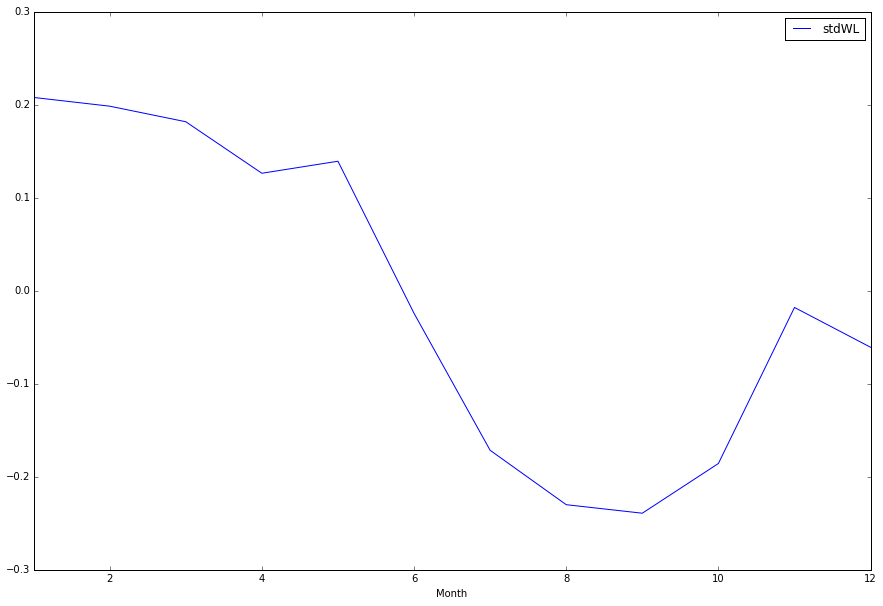

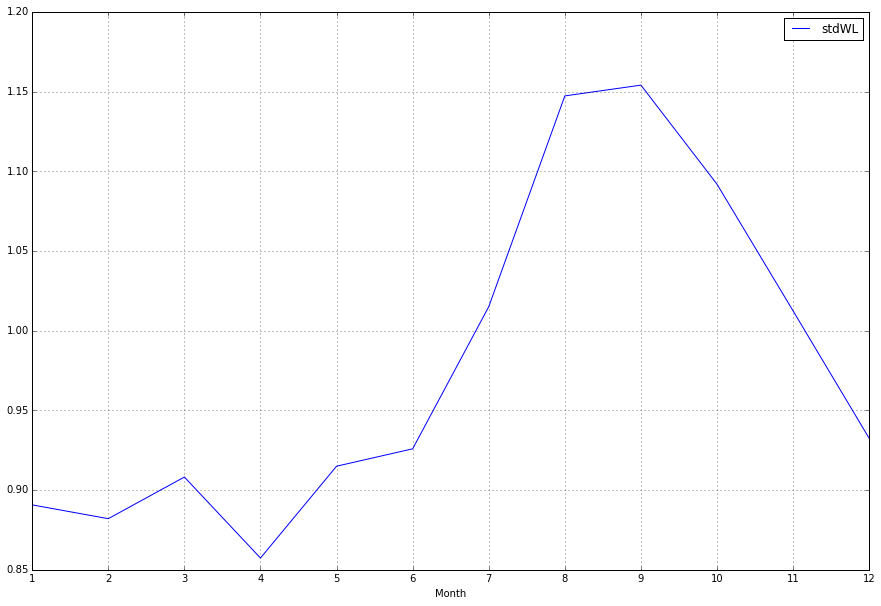

In [55]:

wlLongStats.groupby(['Month'])['stdWL'].mean().to_frame().plot()
wlLongStats.groupby(['Month'])['stdWL'].std().to_frame().plot()

#wlLongStats.groupby(['Month'])['stdWL'].(np.mean+np.std).plot()
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid()

In [2]:
import matplotlib.dates 
from matplotlib.dates import YearLocator

fig = plt.figure()
ax = fig.gca()

wlLongStatsGroups = wlLongStats.groupby(['date'])['stdWL'].agg([np.mean,np.median,np.std])

x = wlLongStatsGroups.index
y = pd.rolling_mean(wlLongStatsGroups['mean'],10)
ax.plot(x,y,label='Average Groundwater Level Variation')

wlLongStatsGroups['meanplusstd'] = wlLongStatsGroups['mean'] + wlLongStatsGroups['std']*2
wlLongStatsGroups['meanminusstd'] = wlLongStatsGroups['mean'] - wlLongStatsGroups['std']*2

#x1 = pd.

ax.fill_between(wlLongStatsGroups.index, wlLongStatsGroups['meanplusstd'], wlLongStatsGroups['meanminusstd'], 
                 facecolor='blue', alpha=0.4, linewidth=0.5, label= "+/-2SD")
locator = YearLocator(2)
minlocator = YearLocator(1)
# Plotting stuff here ...
# Set major x ticks on Mondays.
plt.xlim('1/1/1945','1/1/2015')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(minlocator)
plt.grid(which='both')
plt.ylabel('z-score')
plt.xticks(rotation=45)
plt.legend()
plt.title('Average Groundwater Level Variation in Cache Valley, Utah and Idaho')

NameError: name 'plt' is not defined

In [ ]:
wlLongStats

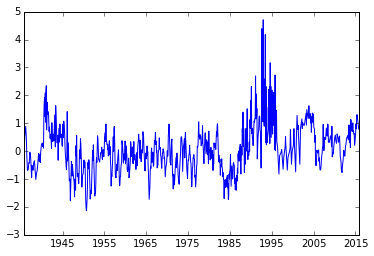

In [47]:
plt.figure()
x = wlLongStatsGroups.index
y = wlLongStatsGroups['mean']
plt.plot(x,y)

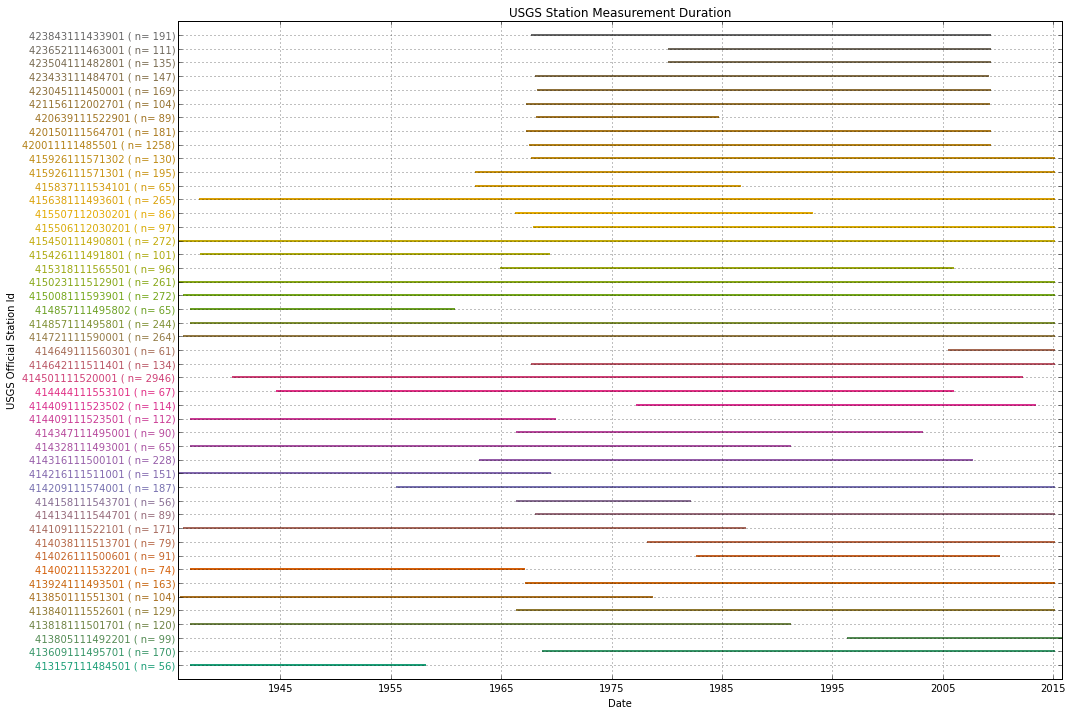

In [48]:
# designate variables
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
from matplotlib.pyplot import cm 
x2 = USGS_Site_Info['amax'].astype(np.datetime64).values
x1 = USGS_Site_Info['amin'].astype(np.datetime64).values
z = USGS_Site_Info['size'].values.astype(np.int)
y = USGS_Site_Info.index.astype(np.int)
names = USGS_Site_Info.site_no.values

labs, tickloc, col = [], [], []

# create color iterator for multi-color lines in gantt chart
color=iter(cm.Dark2(np.linspace(0,1,len(y))))

plt.figure(figsize=[20,20])
fig, ax = plt.subplots()

# generate a line and line properties for each station
for i in range(len(y)):
    c=next(color)
    
    plt.hlines(i+1, x1[i], x2[i], label=y[i], color=c, linewidth=2)
    labs.append(str(names[i]).title()+" ( n= "+str(z[i])+")")
    tickloc.append(i+1)
    col.append(c)
plt.ylim(0,len(y)+1)
plt.yticks(tickloc, labs)

# create custom x labels
#plt.xticks(np.arange(datetime(np.min(x1).year,1,1),np.max(x2)+timedelta(days=365.25),timedelta(days=365.25*5)),rotation=45)
#plt.xlim(datetime(np.min(x1).year,1,1),np.max(x2)+timedelta(days=365.25))
plt.xlabel('Date')
plt.ylabel('USGS Official Station Id')
plt.grid()
plt.title('USGS Station Measurement Duration')
# color y labels to match lines
gytl = plt.gca().get_yticklabels()
for i in range(len(gytl)):
    gytl[i].set_color(col[i])
plt.tight_layout()

plt.savefig('E:\\PROJECTS\\UMAR\\Data\\USGS\\gantt.pdf')

In [49]:
stationWL['Year']

date
1968-10-24    1968
1968-10-23    1968
1936-10-14    1936
1936-12-14    1936
1937-01-17    1937
1937-03-12    1937
1937-05-12    1937
1937-08-07    1937
1937-12-16    1937
1938-02-09    1938
1938-04-19    1938
1938-06-24    1938
1938-08-19    1938
1938-10-14    1938
1938-12-09    1938
1939-02-07    1939
1939-04-04    1939
1939-06-01    1939
1939-08-05    1939
1939-10-03    1939
1939-12-28    1939
1940-02-07    1940
1940-03-09    1940
1940-04-01    1940
1940-05-01    1940
1940-06-24    1940
1940-10-11    1940
1941-03-12    1941
1941-10-09    1941
1941-12-10    1941
              ... 
2001-11-21    2001
2002-03-14    2002
2002-05-28    2002
2002-09-26    2002
2002-11-08    2002
2003-03-19    2003
2003-05-05    2003
2003-09-10    2003
2003-11-24    2003
2004-03-24    2004
2004-05-27    2004
2004-09-13    2004
2004-11-15    2004
2005-03-28    2005
2005-05-17    2005
2005-09-15    2005
2005-11-30    2005
2006-03-29    2006
2006-05-16    2006
2006-09-14    2006
2006-11-01    2006
2007-03

In [56]:
wlLongStats.to_csv('E:\\PROJECTS\\UMAR\\Data\\USGS\\AvgWLs_HUC_16010203.csv')

In [ ]:
z = stationWL.wlelev.values
x = stationWL.UTM_X.values
y = stationWL.UTM_Y.values

http://connor-johnson.com/2014/03/20/simple-kriging-in-python/

http://stackoverflow.com/questions/31124930/ckdtree-vs-dsearchn?lq=1

In [ ]:
import numpy as np
from scipy.spatial import cKDTree
A = np.loadtxt('A.txt')
B = np.loadtxt('B.txt')
tree = cKDTree( B[:,[1,2,3]] )
d, inds = tree.query( A[:,[1,2,3]], k=1, p=2)
B_new = B[inds]
xyz_near = np.hstack(( B_new[:,0:4], A[:,0:4] ))

for j, a in enumerate(A):
    # compute 2-norms from each point in B to a
    dd = np.sqrt(((a[1:] - B[:,1:])**2).sum(axis=1))
    # find closest point
    jx = np.argmin(dd)
    # check solution
    assert inds[j] == jx
    assert np.allclose(d[j], dd.min())
    # check it is unique
    assert (dd[jx+1:] > d[j]).all()
    assert (dd[:jx] > d[j]).all()

print("All OK")

## Visualizing Data

## Exporting Figures

The following script will generate a series of box and whisker plots and save them in a pdf. It makes a box plot for each station, breaking the data into monthly intervals.  Make sure to change the directory name in the script so it ends up in a recognizable place on your computer.  

In [ ]:
# create dictionary of integers and their month equivalent
months = {'1':'Jan.', '2':'Feb.', '3':'Mar.', '4':'Apr.', '5':'May', '6':'Jun.', 
         '7':'Jul.', '8':'Aug.', '9':'Sep.', '10':'Oct.', '11':'Nov.', '12':'Dec.', 'Total':'Total'}
# create empty dictionary to hold pandas Dataframes
j = {}


with PdfPages(rootname + 'station_boxplots.pdf') as pdfs:
    ymax = 10000
    ymin = 0.01
    for i in range(len(sites)):
        # make a dataframe containing summary statistics and store it in the j dictionary
        j[sites[i]] = USGS_Site_Data.groupby('mon')[sites[i]].agg({'min':np.min, 'mean':np.mean, 
                                                                   'median':np.median, 'max':np.max, 'std':np.std, 
                                                                   'cnt':(lambda x: np.count_nonzero(~np.isnan(x)))}).reset_index()
        # make a list of the custom lables you will use for your boxplot; this one will show the number of samples used to make the plot
        labs = [months[(str(j[sites[i]]['mon'][b]))] + " (n=" + str(int(j[sites[i]]['cnt'][b])) + ")" for b in range(len(j[sites[i]]))]
        # designate the location of each custom label
        tickloc = [b+1 for b in range(len(j[sites[i]]['mon']))]
        
        plt.figure()
        USGS_Site_Data.boxplot(column=sites[i],by='mon', rot=70)
        strtdt = str(USGS_Site_Info.ix[sites[i],'start_date'])[0:10]
        findt = str(USGS_Site_Info.ix[sites[i],'fin_date'])[0:10]
        siteName = USGS_Site_Info.ix[sites[i],'name'].title() 
        plt.title( siteName + ' (' + sites[i] + ')  ' + strtdt + ' to ' + findt )
        plt.suptitle('')
        plt.yscale('log')
        plt.ylabel('Discharge (cfs)')
        plt.ylim((ymin,ymax))
        plt.xlabel('Month')
        # here is where your lists for the custom label come into play
        plt.xticks(tickloc, labs)
        
        pdfs.savefig()

        plt.close()
    # Save metadata of the pdf so you can find it later
    d = pdfs.infodict()
    d['Title'] = 'Monthly Station USGS Boxplots UMSS'
    d['Author'] = u'Paul C. Inkenbrandt\xe4nen'
    d['Subject'] = 'Boxplots of several USGS Surface Stations'
    d['Keywords'] = 'USGS Surface NWIS Boxplot'
    d['CreationDate'] = datetime.today()
    d['ModDate'] = datetime.today()

Let's plot a few of the boxplots so you can see what they look like.

In [ ]:
for i in range(1,3):
    j[sites[i]] = USGS_Site_Data.groupby('mon')[sites[i]].agg([np.min, np.mean, np.median, np.max, np.std, np.size]).reset_index()
    # make a list of the custom lables you will use for your boxplot; this one will show the number of samples used to make the plot
    labs = [months[(str(j[sites[i]]['mon'][b]))] + " (n=" + str(int(j[sites[i]]['size'][b])) + ")" for b in range(len(j[sites[i]]))]
    # designate the location of each custom label
    tickloc = [b+1 for b in range(len(j[sites[i]]['mon']))]

    plt.figure()
    USGS_Site_Data.boxplot(column=sites[i],by='mon', rot=70)
    plt.title(USGS_Site_Info.ix[sites[i],'name'].title() + ' (' + sites[i] + ')')
    plt.suptitle('')
    plt.yscale('log')
    plt.ylabel('Discharge (cfs)')
    plt.ylim((ymin,ymax))
    plt.xlabel('Month')
    # here is where your lists for the custom label come into play
    plt.xticks(tickloc, labs)
    plt.show()
    plt.close()

This script will generate boxplots showing all of the station data.

In [ ]:
# This script summarizes discharge for all sites and limits the number of box plots on one graph to the n variable
j=0
with PdfPages(rootname + 'sum_boxplots.pdf') as pdf:
    while j < len(sites):
        ymax = 10000
        ymin = 0.01
        n=10
        # if statement allows for uneven number of sites on last page
        if j+n >= len(sites):
            plt.figure()
            USGS_Site_Data[sites[j:-1]].plot(kind='box')
            plt.title('Sites '+sites[j]+' to '+sites[-1] )
            plt.yscale('log')
            plt.xlabel('USGS Site')
            plt.xticks(rotation=45)
            plt.ylabel('discharge (cfs)')
            plt.ylim((ymin,ymax))
            pdf.savefig()
            plt.show()
            plt.close()
            j = j+n
        else:
            plt.figure()
            USGS_Site_Data[sites[j:j+n]].plot(kind='box')
            plt.title('Sites '+sites[j]+' to '+sites[j+n] )
            plt.yscale('log')
            plt.xlabel('USGS Site')
            plt.xticks(rotation=45)
            plt.ylabel('discharge (cfs)')
            plt.ylim((ymin,ymax))
            pdf.savefig()
            plt.show()
            plt.close()
            j = j+n
        # Save metadata of the pdf so you can find it later
        d = pdf.infodict()
        d['Title'] = 'Summary USGS Boxplots UMSS'
        d['Author'] = u'Paul C. Inkenbrandt\xe4nen'
        d['Subject'] = 'Boxplots of several USGS Surface Stations'
        d['Keywords'] = 'USGS Surface NWIS Boxplot'
        d['CreationDate'] = datetime.today()
        d['ModDate'] = datetime.today()

We should also produce hydrographs of each station.

In [ ]:
xmax = USGS_Site_Data.index.astype(datetime).values[-1]
xmin = USGS_Site_Data.index.astype(datetime).values[0]

pdfs = PdfPages(rootname + 'station_hydrographs.pdf')
ymax = 10000
ymin = 0.1
for i in range(len(sites)):
    x = USGS_Site_Data.index.values
    y = USGS_Site_Data[sites[i]].values
    plt.figure()
    plt.plot(x,y)
    strtdt = str(USGS_Site_Info.ix[sites[i],'start_date'])[0:10]
    findt = str(USGS_Site_Info.ix[sites[i],'fin_date'])[0:10]
    siteName = USGS_Site_Info.ix[sites[i],'name'].title() 
    plt.title( siteName + ' (' + sites[i] + ')  ' + strtdt + ' to ' + findt )
    plt.suptitle('')
    plt.yscale('log')
    plt.ylabel('Discharge (cfs)')
    plt.ylim((ymin,ymax))
    plt.xlabel('Year')
    plt.xticks(np.arange(datetime(1905,1,1),xmax+timedelta(days=365.25),timedelta(days=365.25*5)),rotation=45)
    plt.xlim(xmin,xmax)
    pdfs.savefig()
    plt.close()
    # Save metadata of the pdf so you can find it later

d = pdfs.infodict()
d['Title'] = 'Monthly Station USGS Hydrographs UMSS'
d['Author'] = u'Paul C. Inkenbrandt\xe4nen'
d['Subject'] = 'Hydrograph of several USGS Surface Stations'
d['Keywords'] = 'USGS Surface NWIS Hydrograph'
d['CreationDate'] = datetime.today()
d['ModDate'] = datetime.today()

In [ ]:
pd.date_range(start=xmin, end=xmax, freq='5AS').year

In [ ]:
xmax = USGS_Site_Data.index[-1]
xmin = USGS_Site_Data.index[0]

plt.figure()
ticks = pd.date_range(start=xmin, end=xmax, freq='4AS')
USGS_Site_Data[sites[0:3]].plot(subplots=True,sharex=True,figsize=(10,8),logy=True, rot=90)
plt.xlim(xmin,xmax)
labs = pd.date_range(start=xmin, end=xmax, freq='4AS').year
plt.xticks(ticks,labs)
plt.show()
plt.close()

In [ ]:
def lumped_hydro(i1,i2):
    pdfs = PdfPages(rootname + 'station_hydrographs_lumped.pdf')
    plt.figure()
    ticks = pd.date_range(start=xmin, end=xmax, freq='4AS')
    USGS_Site_Data[sites[i1:i2]].plot(subplots=True, sharex=True, figsize=(10,24),logy=True, rot=90)
    plt.xlim(xmin,xmax)
    labs = pd.date_range(start=xmin, end=xmax, freq='4AS').year
    plt.xticks(ticks,labs)
    pdfs.savefig()
    plt.close()

In [ ]:
lumped_hydro(0,10)
lumped_hydro(10,20)

In [ ]:
lumped_hydro(20,30)
lumped_hydro(30,-1)

This script will iteratively produce Flow Duration Curves for each of the stations. A flow duration curve is a <a href=http://www.itl.nist.gov/div898/handbook/eda/section3/eda362.htm#PPF>percent point function (ppf)</a>, displaying discharge as a function of probability of that discharge occuring. The ppf is the inverse of the better known <a href=http://www.itl.nist.gov/div898/handbook/eda/section3/eda362.htm#CDF>cumulative distribution function (cdf)</a>. See <a href=http://pubs.usgs.gov/wsp/1542a/report.pdf>this USGS publication</a> for more information.

In [ ]:
with PdfPages(rootname+'station_fdc.pdf') as pdf:
    ymax = 10000
    ymin = 0.01
    for i in range(len(sites)):
        plt.figure()
        fdc_simple(USGS_Site_Data,sites[i],1900,2015)
        fdc_simple(USGS_Site_Data,sites[i],1900,1970)
        fdc_simple(USGS_Site_Data,sites[i],1970,2015)
        plt.ylim(0.01,10000)
        plt.xlim(-.05,1.05)
        plt.grid(which = 'both')
        plt.legend()
        plt.xlabel('probability that discharge was exceeded or equaled')
        plt.title('Flow duration curve for ' + str(USGS_Site_Info['name'][i]).title() + ' ('+ sites[i] +')'+'\n'+
                  'Record: ' + str(USGS_Site_Info['start_date'][i])[0:10] + ' to ' + str(USGS_Site_Info['fin_date'][i])[0:10])
        plt.yscale('log')
        plt.ylabel('discharge (cfs)')
        plt.xticks(np.arange(0,1.05,0.05))
        pdf.savefig()
        plt.close()
    # Save metadata of the pdf so you can find it later
    d = pdf.infodict()
    d['Title'] = 'Flow Duration Curves USGS'
    d['Author'] = u'Paul C. Inkenbrandt\xe4nen'
    d['Subject'] = 'Flow Duration Curves of several USGS Surface Stations'
    d['Keywords'] = 'USGS Surface NWIS FDC Flow Duration'
    d['CreationDate'] = datetime.today()
    d['ModDate'] = datetime.today()

In [ ]:
def dic2df(dic,head):
    df = pd.DataFrame(data=dic)
    df = df.transpose()
    df.columns = [str(head)+'_var1',str(head)+'_var2',str(head)+'_var3',str(head)+'_var4',str(head)+'_r2',str(head)+'_err']
    return df

http://stackoverflow.com/questions/15408371/cumulative-distribution-plots-python <br>
http://hydroclimpy.sourceforge.net/installation.html

Run the following script if you want to see a map of your stations.  This assumes that you have the <a href=http://sourceforge.net/projects/matplotlib/files/matplotlib-toolkits/>Basemap package</a> installed.

In [ ]:
from mpl_toolkits.basemap import Basemap
X = USGS_Site_Info['longitude'].astype(float).values.tolist()
Y = USGS_Site_Info['latitude'].astype(float).values.tolist()

n = 0.05 
m = Basemap(llcrnrlon=min(X)+n,llcrnrlat=min(Y)+n,urcrnrlon=max(X)+n,urcrnrlat=max(Y)+n,
            resolution='h',projection='cyl',lon_0=np.mean(X),lat_0=np.mean(Y))
m.drawrivers(color='blue',linewidth=0.5)
m.drawcounties(color='red',linewidth=0.5)
m.arcgisimage()
#m.etopo(scale=0.5)
lons = X
lats = Y
x,y = m(lons,lats)
m.plot(x,y,'ro', markersize=8)

#m.drawmapscale(lon=-114, lat=43.5, length=100, lon0=-114, lat0=39, barstyle='simple', units='km')